In [1]:
%matplotlib inline
%pdb off

from pprint import pprint
import itertools
import numpy

from metrics import wer, cew, ssr, average, hreff
import montecarlo
import market
import dms
import withdrawal
import mortality
from portfolio import Portfolio
import harvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

Automatic pdb calling has been turned OFF


In [2]:
def run_one_new(dataset, strategy, hreff_floor=4, debug_cashflows=True):
    p = Portfolio(600000, 400000)
    h = strategy(p).harvest()
    h.send(None)
    w = withdrawal.VPW(p, h, years_left=35).withdrawals()
    
    def add_debug_log(annual):
        if debug_cashflows:
            debug.append({
                'Returns' : annual.returns,
                'Withdraw' : annual.withdraw_n,
                'Portfolio' : annual.portfolio_n,
                'Withdraw Orig' : annual.withdraw_pct_orig,
                'Stocks' : annual.portfolio_stocks,
                'Bonds' : annual.portfolio_bonds,
            })


    cashflows = []
    returns = []
    debug = []


    # Initial withdrawal at start of retirement
    annual = w.send(None)
    add_debug_log(annual)
    
    cashflows.append(annual.withdraw_pct_orig)
    
    for i in dataset:
        annual = w.send(i)
        add_debug_log(annual)

        returns.append(annual.returns)
        cashflows.append(annual.withdraw_pct_orig)

    if debug_cashflows:
        pandas.DataFrame(data=debug).to_csv('WERCOMP-cashflows-%s.csv' % strategy.__name__)

    w = wer(cashflows, returns)
    h = hreff(cashflows, returns, floor=D(hreff_floor)/100)
    return (w, h, returns)

In [3]:
def new_calc(strategies, returns):
    wer_df = pandas.DataFrame(index=numpy.arange(0, 1), columns=[s.__name__ for s in strategies])
    hreff_df = pandas.DataFrame(index=numpy.arange(0, 1), columns=[s.__name__ for s in strategies])
    returns_df = pandas.DataFrame(index=numpy.arange(0, 1), columns=[i for i in range(60)])

    pairs = zip(strategies, itertools.tee(returns, len(strategies)))

    for (s, r) in pairs:
        (wer, hreff, returns) = run_one_new(r, s)
        wer_df.loc[0][s.__name__] = wer
        hreff_df.loc[0][s.__name__] = hreff

        returns_df.loc[0] = returns + [None for _ in range(60-30)]
            
    return (wer_df, hreff_df, returns_df)

In [4]:
m = market.Returns_US_1871()
retirement = [m.random_year() for x in range(30)]

In [5]:
strategies = [
    harvesting.N_60_RebalanceHarvesting,
#    harvesting.N_100_RebalanceHarvesting,
    harvesting.PrimeHarvesting,
#    harvesting.AltPrimeHarvesting,
    harvesting.BondsFirst,
#    harvesting.OmegaNot,
#    harvesting.Weiss,
#    harvesting.AgeBased_100,
#    harvesting.AgeBased_110,
#    harvesting.AgeBased_120,
#    harvesting.Glidepath,
    harvesting.ActuarialHarvesting,
]

wer_df, hreff_df, returns_df = new_calc(strategies, retirement)

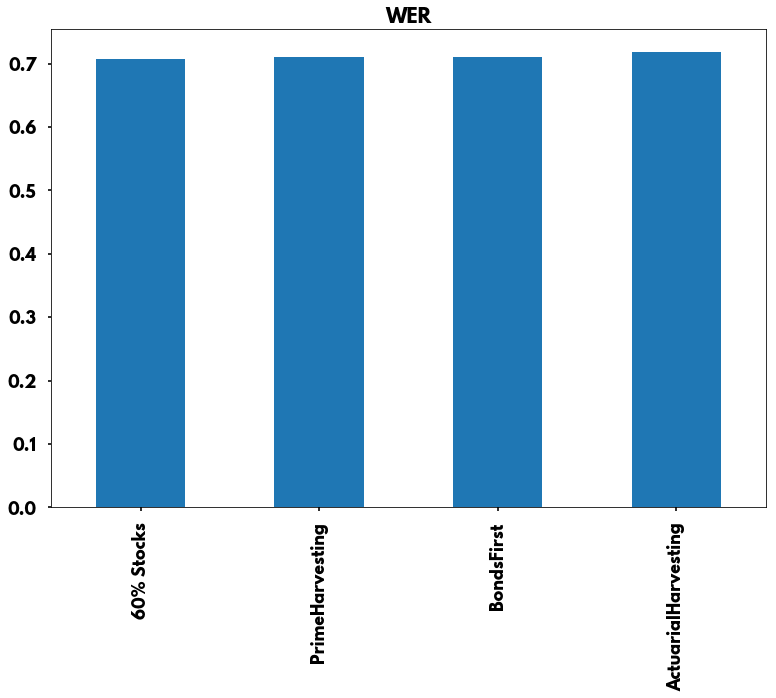

In [6]:
d = [(col, series.mean()) for (col, series) in wer_df.iteritems()]
series = pandas.Series(dict(d))

series.sort_values(inplace=True)
series.plot(kind='bar', title='WER')
#print(series)

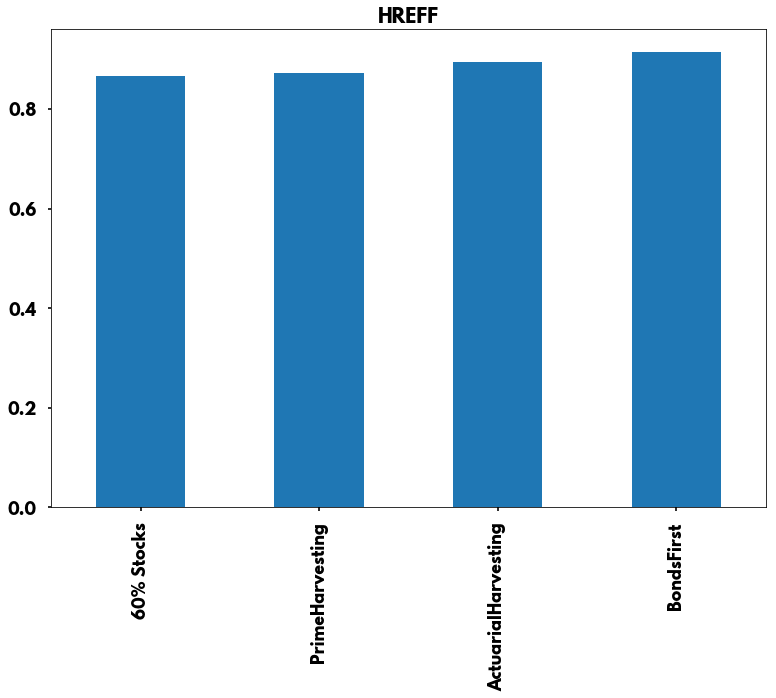

In [7]:
d = [(col, series.mean()) for (col, series) in hreff_df.iteritems()]
series = pandas.Series(dict(d))

series.sort_values(inplace=True)
series.plot(kind='bar', title='HREFF')